# Линейная регрессия: переобучение и регуляризация

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Датасет **"bikes_rent.csv"** хранит дни, для которых записана календарная информация, погодные условия и число прокатов велосипедов.

In [2]:
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Из источника данных:
- season: 1 - весна, 2 - лето, 3 - осень, 4 - зима
- yr: 0 - 2011, 1 - 2012
- mnth: от 1 до 12
- holiday: 0 - нет праздника, 1 - праздничный день
- weekday: от 0 до 6
- workingday: 0 - нерабочий, 1 - рабочий
- weathersit: балгоприятность погоды (1 - ясный день, 4 - ливень, туман)
- temp: температура в Цельсиях
- atemp: температура по ощущениям в Цельсиях
- hum: влажность
- windspeed(mph): скорость ветра миль/час
- windspeed(ms): скорость ветра метр/секунда
- cnt: количество арендованных велосипедов

Будем предсказывать значение последней колонки - количество арендованных велоспидеов.
Посмотрим, как это значение зависит от остальных признаков.

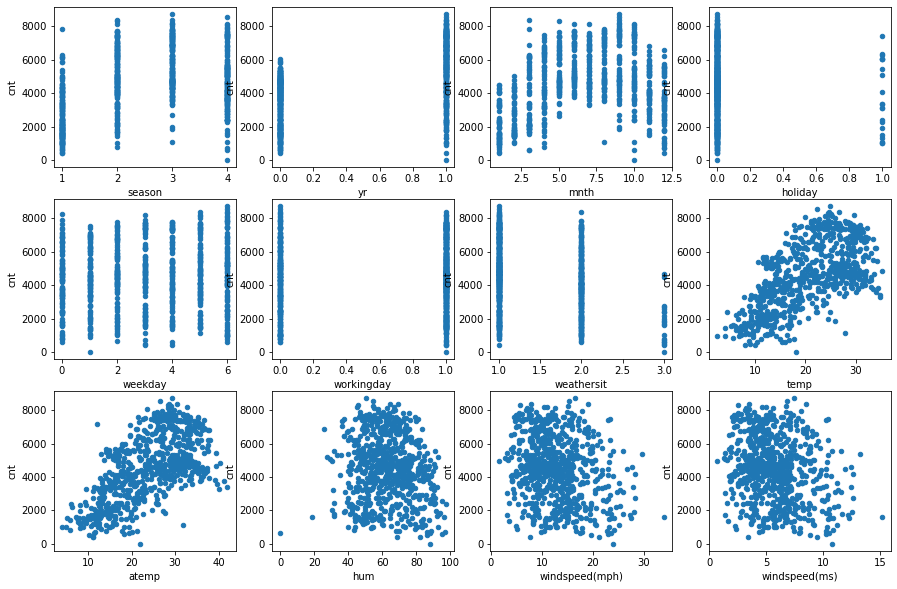

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for index, feature in enumerate(df.columns[:-1]):
    df.plot(feature, 'cnt', subplots=True, kind='scatter', ax=axes[index // 4, index % 4])

Видно, что, начиная с весны и до середины осени, число прокатов растёт.
Так же, скорее всего, целевой признак зависит от температуры (tmp, atmp) линейно.

Проверим это более строго. Рассчитаем кореляции целового признака с остальными:

In [4]:
df.iloc[:, :-1].corrwith(df['cnt'])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

Действительно, в выборке есть признаки, коррелирующие с целевым. Попробуем решить задачу линейными методами.

Ещё заметим, что по графику видно сходство распредления у признаков **"temp"** - **"atem"** и **"windspeed(mph)"** - **"windspeed(ms)"**. Поэтому посмотрим на их попарную корреляцию:

In [5]:
df.loc[:, ['temp', 'atemp', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()

,temp,atemp,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,-0.183643,-0.183643,0.631066
windspeed(mph),-0.157944,-0.183643,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.234545,-0.234545,1.000000


Действительно, **"temp"** и **"atemp"**, а так же **"windspeed(mph)"** и **"windspeed(ms)"** сильно коррелированы.

Теперь оценим масштаб признаков и доли классов в бинарных признаках:

In [6]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Масштабы отличаются, это лучше учесть при построении матрицы признаков (нормировать её).

## Влияние наличия сильно коррелированных признаков на обучение

In [7]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

Перемашем выборку и отнормируем матрицу признаков:

In [8]:
df_shuffled = shuffle(df, random_state=1)
X = scale(df_shuffled.iloc[:, :-1])
y = df_shuffled['cnt']

Обучим линейную регрессию и посмотрим на получившиейся веса:

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
for weight, feature in zip(linear_regressor.coef_, df.columns):
    print("{0:<15}: {1}".format(feature, weight))

season         : 570.868399411367
yr             : 1021.9665162446486
mnth           : -141.3025826073266
holiday        : -86.75672842762894
weekday        : 137.22187647774732
workingday     : 56.393800850321576
weathersit     : -330.2293220763632
temp           : 367.4688332605511
atemp          : 585.5635623010471
hum            : -145.61102505911873
windspeed(mph) : 12457738119011.8
windspeed(ms)  : -12457738119210.254


Видно, что у коллинеарных признаков коэффициенты на порядок выше, чем у других.

Так как в матрице признаков *X* есть линейно зависимые столбцы, она становится вырожденной, из-за чего формула 

$w= (X^TX)^{-1} X^T y$

становится некорректной.

Для решения этой проблемой воспользуемя L-1 (Lasso) и L-2 (Ridge) регуляризацией. Убедимся, что проблема с весами решена:

In [11]:
from sklearn.linear_model import Lasso, Ridge

In [12]:
lasso_model = Lasso(random_state=1)
lasso_model.fit(X, y)
for feature, weight in zip(df.columns, lasso_model.coef_):
    print("{0:<15}: {1}".format(feature, weight))

season         : 560.2416160308867
yr             : 1019.4634940657194
mnth           : -128.7306270367873
holiday        : -86.15278133371102
weekday        : 137.3478939049633
workingday     : 55.212370641356735
weathersit     : -332.3698569623486
temp           : 376.36323620969597
atemp          : 576.5307935045538
hum            : -144.12915500348598
windspeed(mph) : -197.13968940248557
windspeed(ms)  : -2.805018768771316e-08


In [13]:
ridge_model = Ridge(random_state=2)
ridge_model.fit(X, y)
for feature, weight in zip(df.columns, ridge_model.coef_):
    print("{0:<15}: {1}".format(feature, weight))

season         : 563.0645722520164
yr             : 1018.948378787529
mnth           : -131.87332028247596
holiday        : -86.74609799709269
weekday        : 138.00511117871892
workingday     : 55.90311037506443
weathersit     : -332.3497884990731
temp           : 386.4578891919317
atemp          : 566.3470470600437
hum            : -145.0713272986724
windspeed(mph) : -99.2594410817967
windspeed(ms)  : -99.25944115433654


Если посмотреть на получившиеся коэффициенты, то видна особенность L-1 регуляризатора: отобор признаков. Вес при одном из коллинеарных признаков (*windspeed(ms)*) стал равен нулю. 

## Неинформативные признаки

Понаблюдаем за тем, как работают Lasso и Ridge при разных коэффициентах регуляризации.

In [14]:
alphas = np.arange(1, 1000, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1]))
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

for index, alpha in enumerate(alphas):
    lasso_model = Lasso(alpha=alpha)
    ridge_model = Ridge(alpha=alpha)
    lasso_model.fit(X, y)
    ridge_model.fit(X, y)
    coefs_lasso[index] = lasso_model.coef_
    coefs_ridge[index] = ridge_model.coef_

Text(0.5, 1.0, 'Ridge')

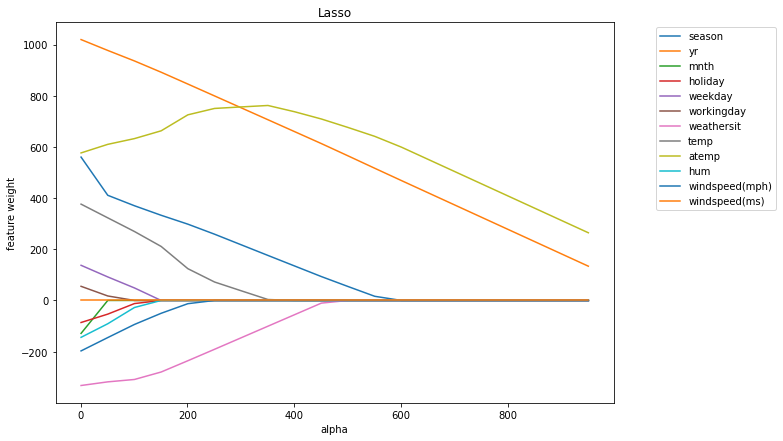

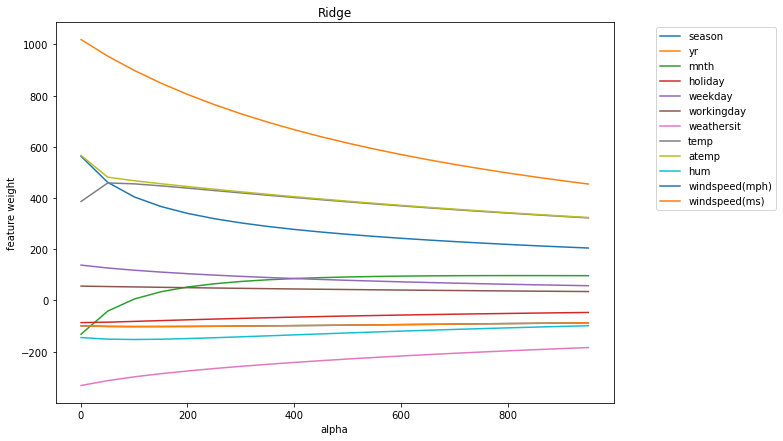

In [15]:
plt.figure(figsize=(10,7))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature)
plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1))
plt.xlabel('alpha')
plt.ylabel('feature weight')
plt.title('Lasso')

plt.figure(figsize=(10, 7))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature)
plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1))
plt.xlabel('alpha')
plt.ylabel('feature weight')
plt.title('Ridge')

Видно, что в случае с L-1 регуляризацей коэффициенты уменьшаются по модулю быстрее.

В случае с Lasso подеберм коэффициент *alpha*. Воспользуемся кросс-валидацией. В качестве метрикик качества возьмём MSE.

In [16]:
from sklearn.linear_model import LassoCV

alpha mse
19    790194.2561342798
18    789909.1201378892
17    789516.2041373855
16    789153.0971226923
15    788820.8611351422
14    788402.2174040466
13    787857.8722778771
12    787351.9915968188
11    786883.5559823182
10    786452.3551817394
9     786058.2384353306
8     785701.0826805303
7     785380.7869387588
6     785097.2683061141
5     784850.4586933034
4     784640.3021599443
3     784468.6052153626
2     784327.0857353084
1     786614.5327252675

selected alpha: 2

season          554.5971259972023
yr              1018.5828191208132
mnth            -122.99242832761972
holiday         -85.58111706346826
weekday         136.3790713369592
workingday      54.48127496490682
weathersit      -332.0079705543427
temp            375.24647249773705
atemp           577.4841395717151
hum             -143.3046086538763
windspeed(mph)  -196.0664803900133
windspeed(ms)   -2.7791988238355936e-08


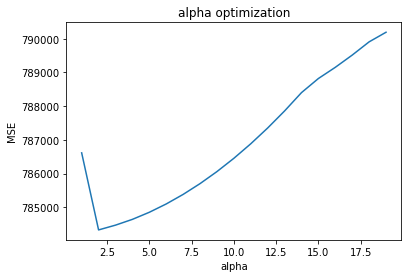

In [43]:
lasso_cv_regressor = LassoCV(alphas=np.arange(1, 20), random_state=3)
lasso_cv_regressor.fit(X, y)
mse_values = np.apply_along_axis(lambda row: row.mean() ,1, lasso_cv_regressor.mse_path_) 

plt.plot(lasso_cv_regressor.alphas_, mse_values)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('alpha optimization')

print("alpha mse")
for alpha, mse in zip(lasso_cv_regressor.alphas_, mse_values):
    print("{0:<5} {1}".format(alpha, mse))

print("\nselected alpha: {}\n".format(lasso_cv_regressor.alpha_))
for feature, weight in zip(df.columns, lasso_cv_regressor.coef_):
    print("{0:<15} {1}".format(feature, weight))

Мы выбрали коэффициент *alpha*. А теперь посмотрим, что было бы, если бы не воспользовались кросс-валидацией.
Посмотрим на минимальные значения *MSE* по каждой выборке и выведем соответсвующие им *alpha*:

In [52]:
min_indexes = np.where(lasso_cv_regressor.mse_path_ == np.amin(lasso_cv_regressor.mse_path_, axis=0))

print("alpha MSE")
for min_mse, alpha in zip(lasso_cv_regressor.mse_path_[min_indexes], lasso_cv_regressor.alphas_[min_indexes[0]]):
    print("{0:<5} {1}".format(alpha, min_mse))

alpha MSE
15    683829.4862956762
4     801817.7742808731
2     817031.4299300781
1     644560.2367541236
1     969288.9396915858


Посмотрим на зависмость *MSE* от *alpha* на каждой выборке отдельно:

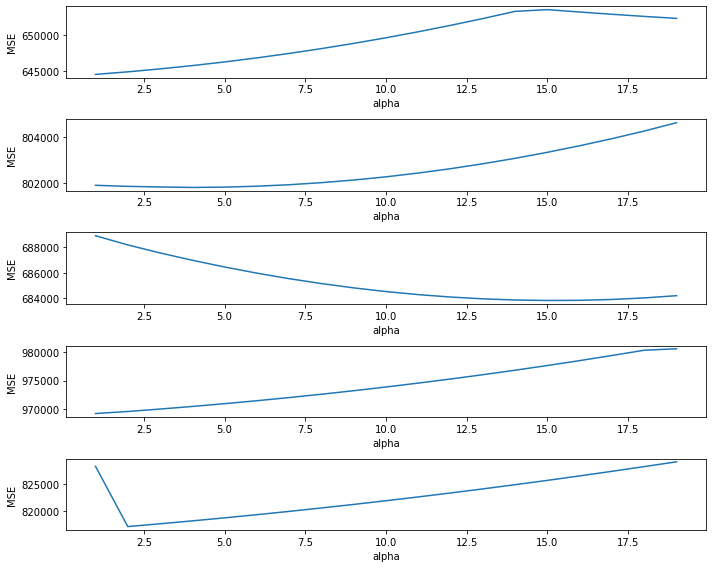

In [73]:
fig, ax = plt.subplots(5, figsize=((10, 8)))

for i in range(lasso_cv_regressor.mse_path_.shape[1]):
    ax[i].plot(lasso_cv_regressor.alphas_, lasso_cv_regressor.mse_path_[:,i])
    ax[i].set(xlabel='alpha', ylabel='MSE')
fig.tight_layout()

Видно, что в зависмости от выборки конкретный *alpha* может иметь большое значение, а может наоборот - оптимальное. Получается, что без использования кросс-валидации мы настраивали *alpha* под конкретную выборку.

## Итоги

Вспомним, как выглядит зависимость *cnt* от различых признаков: 

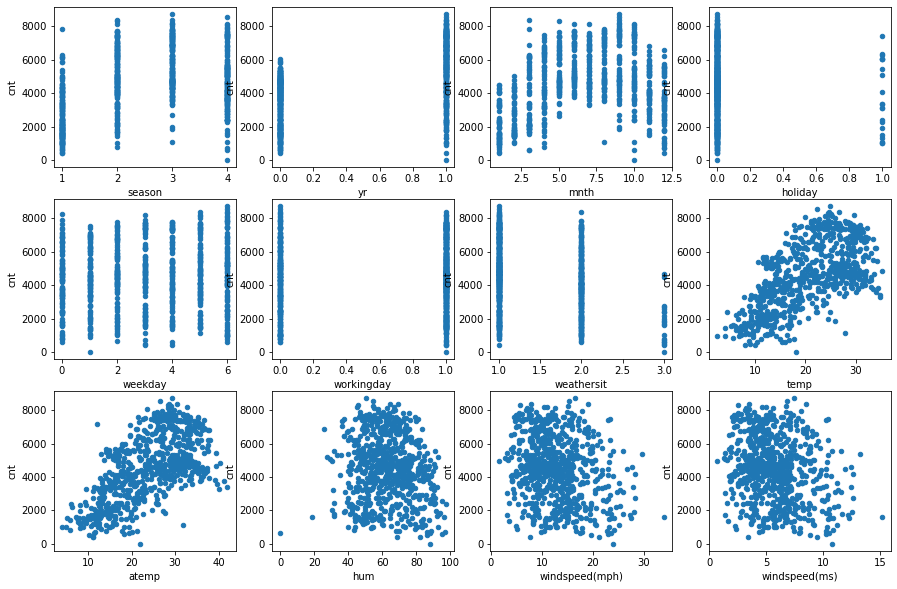

In [76]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for index, feature in enumerate(df.columns[:-1]):
    df.plot(feature, 'cnt', subplots=True, kind='scatter', ax=axes[index // 4, index % 4])

Вернемся к полученным коэффициентам:

In [74]:
for feature, weight in zip(df.columns, lasso_cv_regressor.coef_):
    print("{0:<15} {1}".format(feature, weight))

season          554.5971259972023
yr              1018.5828191208132
mnth            -122.99242832761972
holiday         -85.58111706346826
weekday         136.3790713369592
workingday      54.48127496490682
weathersit      -332.0079705543427
temp            375.24647249773705
atemp           577.4841395717151
hum             -143.3046086538763
windspeed(mph)  -196.0664803900133
windspeed(ms)   -2.7791988238355936e-08


Самые большие значения коэффициентов у признаков *season*, *yr*, *atemp*. Посмотрев на графики, можно предположить, что зависимость *cnt* от этих признаков прямо пропорциональная и ближе всех к линейной среди остальных зависимостей.

Самые маленькие значения весов у *windspeed(mph)*, *hum*, *weathersit*. Это соотвествуют здравому смыслу. Ведь мало кто захочет брать велосипед на прокат при плохой погоде, а значит между этими признаками и целевым обратно пропорциональная зависимость.

Модель исключила признак *windspeed(ms)*, который был коллинеарен с *windspeed(mph)*. Это ожидаемое поведение.

Мы убедились в том, что при выборе параметров модели очень легко подобрать их под конкретные данные и переобучится.